<a href="https://colab.research.google.com/github/felipebita/credit_risk/blob/main/notebook/credit_risk_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Imports and functions** teste


In [ ]:
import numpy             as np
import pandas            as pd
import pickle
import os
import re
import xgboost as xgb

#visualization
import seaborn           as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#models
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.neural_network  import MLPClassifier
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier

#metrics and assistants
from sklearn.metrics         import confusion_matrix, balanced_accuracy_score, precision_score, classification_report, recall_score, f1_score, make_scorer, cohen_kappa_score, roc_curve, auc
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV


In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
from category_encoders       import OneHotEncoder

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
def ml_cv_results(model_name, model, x, y, seed,verbose=1):
    '''initial'''
    balanced_accuracies = []
    balanced_accuracies_sc = []
    precisions = []
    precisions_sc = []
    recalls = []
    recalls_sc = []
    f1s = []
    f1s_sc = []
    kappas = []
    kappas_sc = []
    roc_auc = []
    roc_auc_sc = []

    mm = MinMaxScaler()
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    count = 0

    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))

        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train].values.ravel(), y.iloc[index_test].values.ravel()

        for n in [1, 2]:
            if n == 1:
                ## training the model
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)
                y_pred_prob = model.predict_proba(x_test)
                y_pred_prob = y_pred_prob[:, 1]
                metrics_list = [balanced_accuracies, precisions, recalls, f1s, kappas, roc_auc]
            else:
                ## applying the scale
                x_train = mm.fit_transform(x_train)
                x_test = mm.transform(x_test)
                ## training the model
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)
                y_pred_prob = model.predict_proba(x_test)
                y_pred_prob = y_pred_prob[:, 1]
                metrics_list = [balanced_accuracies_sc, precisions_sc, recalls_sc, f1s_sc, kappas_sc, roc_auc_sc]

            ## saving the metrics
            metrics_list[0].append(balanced_accuracy_score(y_test, y_pred))
            metrics_list[1].append(precision_score(y_test, y_pred))
            metrics_list[2].append(recall_score(y_test, y_pred))
            metrics_list[3].append(f1_score(y_test, y_pred))
            metrics_list[4].append(cohen_kappa_score(y_test, y_pred))

            # saving auc
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
            metrics_list[5].append(auc(fpr, tpr))


    '''results'''
    metric_names = ["Balanced Accuracy", "Precision", "Recall", "F1", "Kappa", "AUC"]
    metric_values = [balanced_accuracies, precisions, recalls, f1s, kappas, roc_auc,
                     balanced_accuracies_sc, precisions_sc, recalls_sc, f1s_sc, kappas_sc, roc_auc_sc]
    finalresult = pd.DataFrame({metric_names[i]: ["{} +/- {}".format(np.round(np.mean(metric_values[i]), 3), np.round(np.std(metric_values[i]), 3)),
                                                  "{} +/- {}".format(np.round(np.mean(metric_values[i+6]), 3), np.round(np.std(metric_values[i+6]), 3))] for i in range(len(metric_names))}, index=[model_name, model_name + " scaled"])

    return finalresult

In [ ]:
def ml_cv_results_2(model_name, model, x, y, seed, verbose=1):
    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    roc_auc = []

    x_ = x.to_numpy()
    y_ = y.to_numpy()
    count = 0

    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))

        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train].values.ravel(), y.iloc[index_test].values.ravel()

        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        y_pred_prob = model.predict_proba(x_test)
        y_pred_prob = y_pred_prob[:, 1]
        metrics_list = [balanced_accuracies, precisions, recalls, f1s, kappas, roc_auc]

        ## saving the metrics
        metrics_list[0].append(balanced_accuracy_score(y_test, y_pred))
        metrics_list[1].append(precision_score(y_test, y_pred))
        metrics_list[2].append(recall_score(y_test, y_pred))
        metrics_list[3].append(f1_score(y_test, y_pred))
        metrics_list[4].append(cohen_kappa_score(y_test, y_pred))

        # saving auc
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        metrics_list[5].append(auc(fpr, tpr))


    '''results'''
    metric_names = ["Balanced Accuracy", "Precision", "Recall", "F1", "Kappa", "AUC"]
    metric_values = [balanced_accuracies, precisions, recalls, f1s, kappas, roc_auc]
                     
    finalresult = pd.DataFrame({metric_names[i]: ["{} +/- {}".format(np.round(np.mean(metric_values[i]), 3), np.round(np.std(metric_values[i]), 3))] for i in range(len(metric_names))}, index=[model_name])

    return finalresult

## **3 - Data Analysis**


### 3.1 - Loading Data

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/github/credit_risk_modeling/cr_loan2.csv")

In [ ]:
dataset.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.00000,PERSONAL,D,35000,16.02000,1,0.59000,Y,3
1,21,9600,OWN,5.00000,EDUCATION,B,1000,11.14000,0,0.10000,N,2
2,25,9600,MORTGAGE,1.00000,MEDICAL,C,5500,12.87000,1,0.57000,N,3
3,23,65500,RENT,4.00000,MEDICAL,C,35000,15.23000,1,0.53000,N,2
4,24,54400,RENT,8.00000,MEDICAL,C,35000,14.27000,1,0.55000,Y,4


### 3.2 - Data Description

**person_age**	Age

**person_income**	Annual Income

**person_home_ownership**	Home ownership

**person_emp_length**	Employment length (in years)

**loan_intent**	Loan intent

**loan_grade**	Loan grade

**loan_amnt**	Loan amount

**loan_int_rate**	Interest rate

**loan_status**	Loan status (0 is non default 1 is default)

**loan_percent_income**	Percent income

**cb_person_default_on_file**	Historical default

**cb_preson_cred_hist_length**	Credit history length

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [ ]:
dataset.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [ ]:
dataset = dataset.dropna()

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


### 3.3 - Statistics Summary

In [ ]:
dataset.describe(exclude= 'object')

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28638.00000,28638.00000,28638.00000,28638.00000,28638.00000,28638.00000,28638.00000,28638.00000
mean,27.72722,66649.37188,4.78867,9656.49312,11.03987,0.21660,0.16949,5.79374
std,6.31044,62356.44740,4.15463,6329.68336,3.22937,0.41194,0.10639,4.03848
min,20.00000,4000.00000,0.00000,500.00000,5.42000,0.00000,0.00000,2.00000
25%,23.00000,39480.00000,2.00000,5000.00000,7.90000,0.00000,0.09000,3.00000
50%,26.00000,55956.00000,4.00000,8000.00000,10.99000,0.00000,0.15000,4.00000
75%,30.00000,80000.00000,7.00000,12500.00000,13.48000,0.00000,0.23000,8.00000
max,144.00000,6000000.00000,123.00000,35000.00000,23.22000,1.00000,0.83000,30.00000


<Axes: xlabel='cb_person_cred_hist_length', ylabel='Density'>

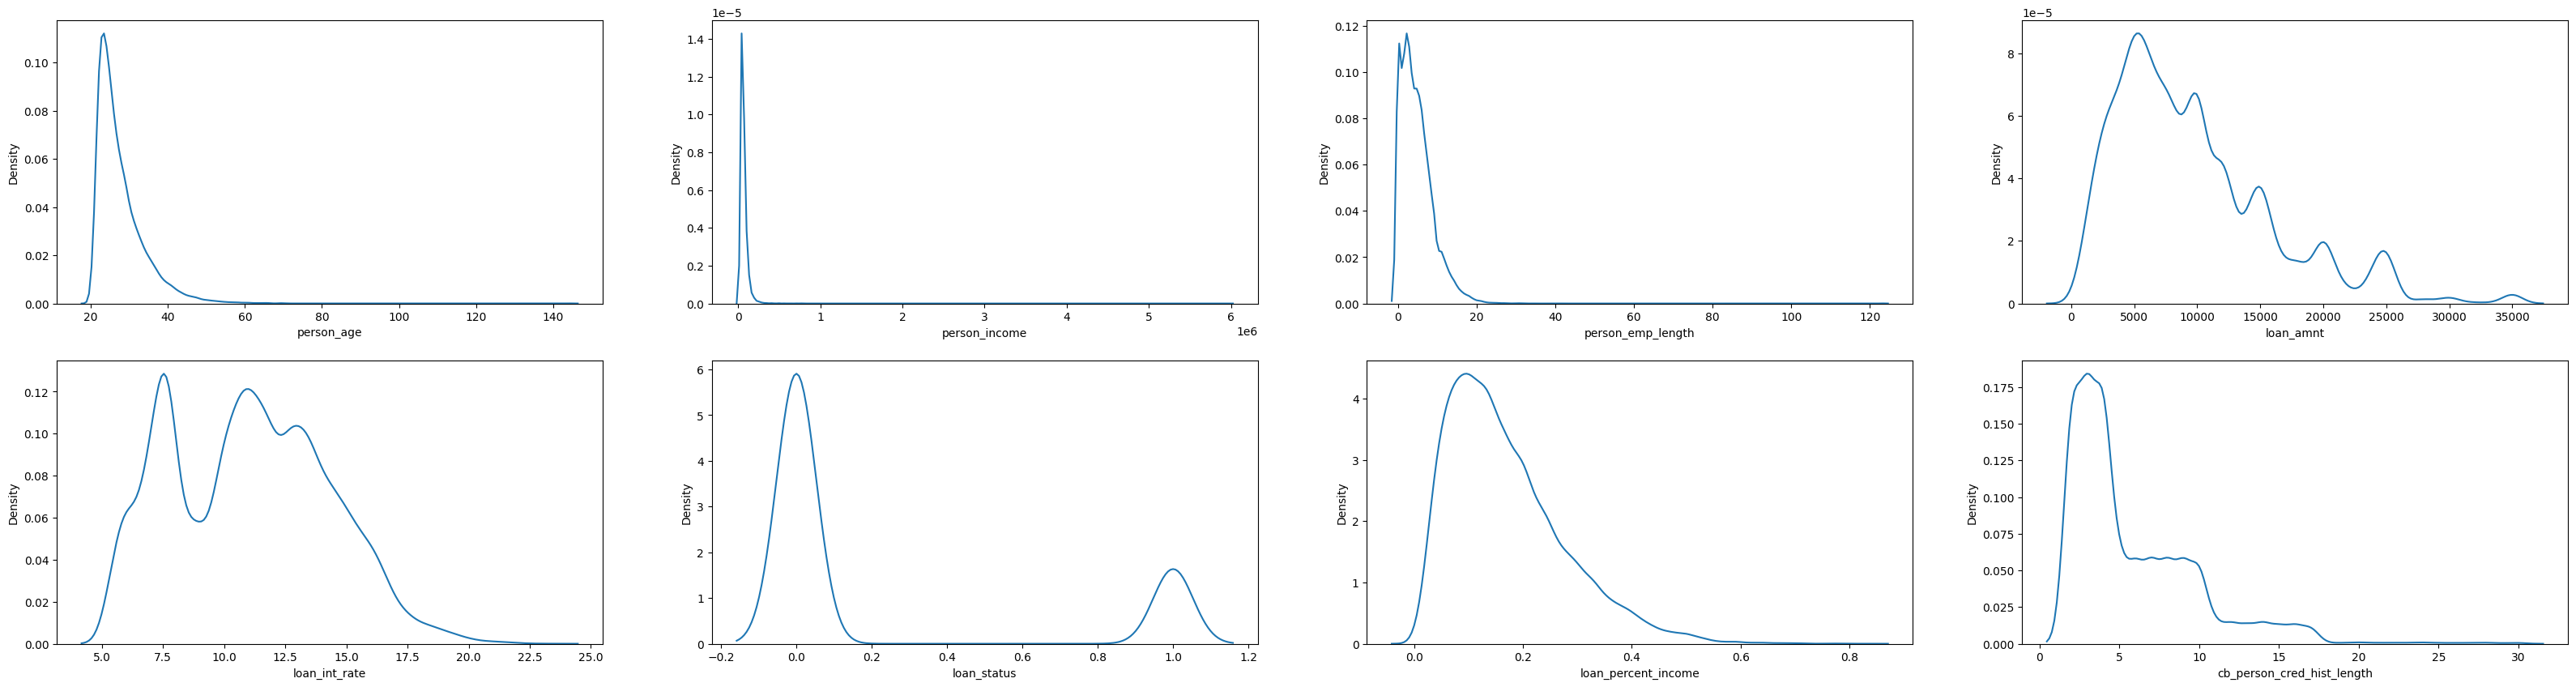

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(40,10))

sns.kdeplot(ax=axes[0,0], x='person_age',  data=dataset)
sns.kdeplot(ax=axes[0,1], x='person_income',  data=dataset)
sns.kdeplot(ax=axes[0,2], x='person_emp_length',  data=dataset)
sns.kdeplot(ax=axes[0,3], x='loan_amnt', data=dataset)
sns.kdeplot(ax=axes[1,0], x='loan_int_rate', data=dataset)
sns.kdeplot(ax=axes[1,1], x='loan_status', data=dataset)
sns.kdeplot(ax=axes[1,2], x='loan_percent_income', data=dataset)
sns.kdeplot(ax=axes[1,3], x='cb_person_cred_hist_length', data=dataset)

In [ ]:
indice = dataset.sort_values('person_age',ascending=False).head(4).index
dataset = dataset.drop(indice)

In [ ]:
indice = dataset.sort_values('person_emp_length',ascending=False).head(2).index
dataset = dataset.drop(indice)

<Axes: xlabel='cb_person_cred_hist_length', ylabel='Density'>

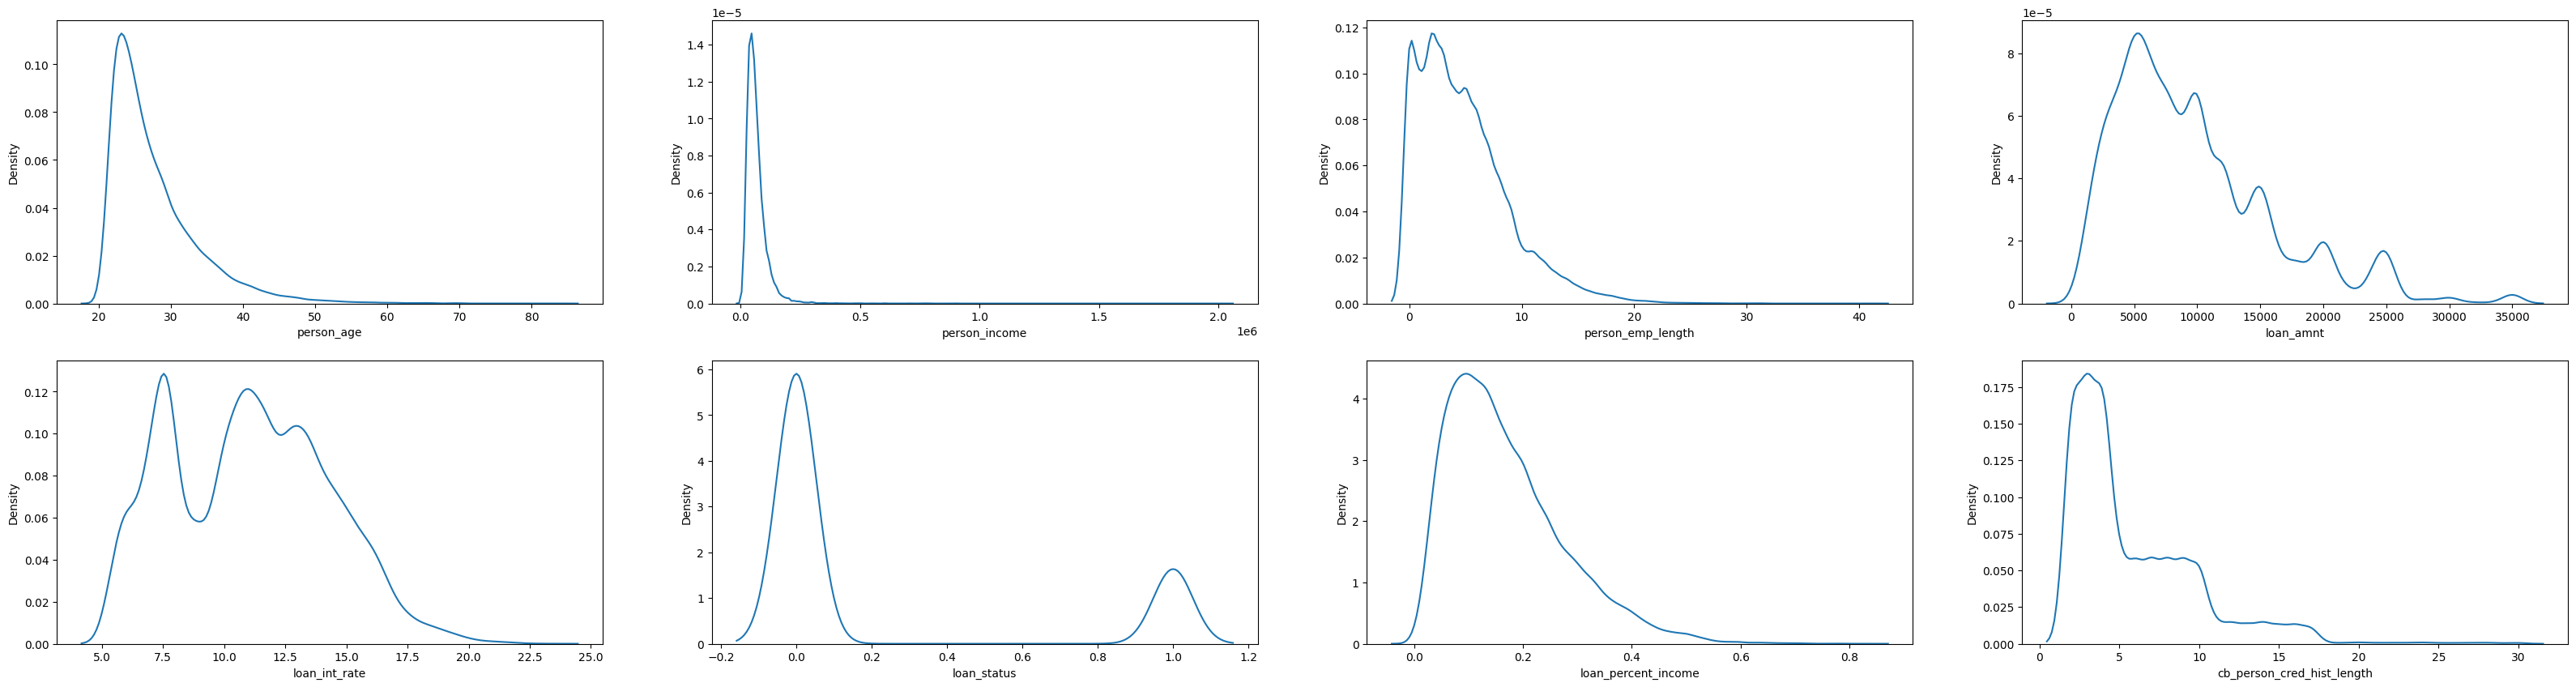

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(40,10))

sns.kdeplot(ax=axes[0,0], x='person_age',  data=dataset)
sns.kdeplot(ax=axes[0,1], x='person_income',  data=dataset)
sns.kdeplot(ax=axes[0,2], x='person_emp_length',  data=dataset)
sns.kdeplot(ax=axes[0,3], x='loan_amnt', data=dataset)
sns.kdeplot(ax=axes[1,0], x='loan_int_rate', data=dataset)
sns.kdeplot(ax=axes[1,1], x='loan_status', data=dataset)
sns.kdeplot(ax=axes[1,2], x='loan_percent_income', data=dataset)
sns.kdeplot(ax=axes[1,3], x='cb_person_cred_hist_length', data=dataset)

In [ ]:
dataset.describe(exclude= 'object')

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28632.00000,28632.00000,28632.00000,28632.00000,28632.00000,28632.00000,28632.00000,28632.00000
mean,27.71214,66426.50559,4.78032,9655.33145,11.03970,0.21661,0.16949,5.79355
std,6.17199,51547.45735,4.03562,6327.79871,3.22941,0.41194,0.10636,4.03713
min,20.00000,4000.00000,0.00000,500.00000,5.42000,0.00000,0.00000,2.00000
25%,23.00000,39456.00000,2.00000,5000.00000,7.90000,0.00000,0.09000,3.00000
50%,26.00000,55900.00000,4.00000,8000.00000,10.99000,0.00000,0.15000,4.00000
75%,30.00000,80000.00000,7.00000,12500.00000,13.48000,0.00000,0.23000,8.00000
max,84.00000,2039784.00000,41.00000,35000.00000,23.22000,1.00000,0.83000,30.00000


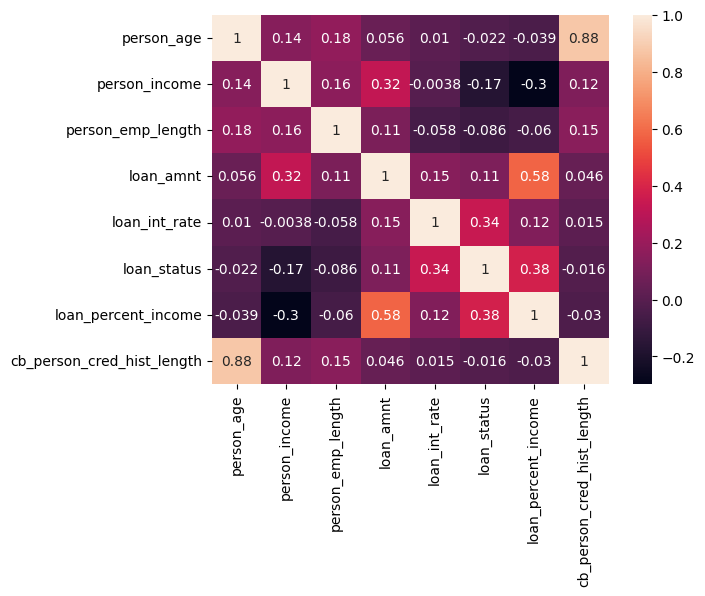

In [ ]:
cont_var = dataset[['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_status','loan_percent_income','cb_person_cred_hist_length']]
corrMatrix = cont_var.corr()
sns.heatmap(corrMatrix, annot=True,annot_kws={"size": 10})
plt.show()

In [ ]:
pd.crosstab(dataset['person_home_ownership'], dataset['loan_status'], margins=True)

loan_status,0,1,All
person_home_ownership,,,
MORTGAGE,10313,1485,11798
OTHER,67,27,94
OWN,2046,146,2192
RENT,10004,4544,14548
All,22430,6202,28632


In [ ]:
pd.crosstab(dataset['person_home_ownership'], dataset['loan_status'], normalize= True, margins=True)

loan_status,0,1,All
person_home_ownership,,,
MORTGAGE,0.36019,0.05187,0.41206
OTHER,0.00234,0.00094,0.00328
OWN,0.07146,0.00510,0.07656
RENT,0.34940,0.15870,0.50810
All,0.78339,0.21661,1.00000


In [ ]:
pd.crosstab(dataset['person_home_ownership'], dataset['loan_status'], normalize= 'columns', margins=True)

loan_status,0,1,All
person_home_ownership,,,
MORTGAGE,0.45979,0.23944,0.41206
OTHER,0.00299,0.00435,0.00328
OWN,0.09122,0.02354,0.07656
RENT,0.44601,0.73267,0.50810


In [ ]:
pd.crosstab(dataset['loan_intent'], dataset['loan_status'], margins=True)

loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,3269,1296,4565
EDUCATION,4731,971,5702
HOMEIMPROVEMENT,2377,821,3198
MEDICAL,3872,1421,5293
PERSONAL,3913,962,4875
VENTURE,4268,731,4999
All,22430,6202,28632


In [ ]:
pd.crosstab(dataset['loan_intent'], dataset['loan_status'],normalize= True, margins=True)

loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,0.11417,0.04526,0.15944
EDUCATION,0.16523,0.03391,0.19915
HOMEIMPROVEMENT,0.08302,0.02867,0.11169
MEDICAL,0.13523,0.04963,0.18486
PERSONAL,0.13667,0.03360,0.17026
VENTURE,0.14906,0.02553,0.17459
All,0.78339,0.21661,1.00000


In [ ]:
pd.crosstab(dataset['loan_intent'], dataset['loan_status'],normalize= 'columns', margins=True)

loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,0.14574,0.20896,0.15944
EDUCATION,0.21092,0.15656,0.19915
HOMEIMPROVEMENT,0.10597,0.13238,0.11169
MEDICAL,0.17263,0.22912,0.18486
PERSONAL,0.17445,0.15511,0.17026
VENTURE,0.19028,0.11787,0.17459


In [ ]:
pd.crosstab(dataset['loan_grade'], dataset['loan_status'], margins=True)


loan_status,0,1,All
loan_grade,,,
A,8497,904,9401
B,7696,1453,9149
C,4540,1157,5697
D,1325,1922,3247
E,308,562,870
F,63,146,209
G,1,58,59
All,22430,6202,28632


In [ ]:
pd.crosstab(dataset['cb_person_default_on_file'], dataset['loan_status'], margins=True)

loan_status,0,1,All
cb_person_default_on_file,,,
N,19254,4276,23530
Y,3176,1926,5102
All,22430,6202,28632


In [ ]:
pd.crosstab(dataset['cb_person_default_on_file'], dataset['loan_status'], normalize= True, margins=True)

loan_status,0,1,All
cb_person_default_on_file,,,
N,0.67246,0.14934,0.82181
Y,0.11092,0.06727,0.17819
All,0.78339,0.21661,1.00000


In [ ]:
pd.crosstab(dataset['cb_person_default_on_file'], dataset['loan_status'], normalize= 'columns', margins=True)

loan_status,0,1,All
cb_person_default_on_file,,,
N,0.85840,0.68946,0.82181
Y,0.14160,0.31054,0.17819


In [ ]:
enc = OneHotEncoder(cols=['person_home_ownership','loan_intent','cb_person_default_on_file'], use_cat_names=True)
dataset = enc.fit_transform(dataset)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28632 entries, 1 to 32580
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      28632 non-null  int64  
 1   person_income                   28632 non-null  int64  
 2   person_home_ownership_OWN       28632 non-null  int64  
 3   person_home_ownership_MORTGAGE  28632 non-null  int64  
 4   person_home_ownership_RENT      28632 non-null  int64  
 5   person_home_ownership_OTHER     28632 non-null  int64  
 6   person_emp_length               28632 non-null  float64
 7   loan_intent_EDUCATION           28632 non-null  int64  
 8   loan_intent_MEDICAL             28632 non-null  int64  
 9   loan_intent_VENTURE             28632 non-null  int64  
 10  loan_intent_PERSONAL            28632 non-null  int64  
 11  loan_intent_HOMEIMPROVEMENT     28632 non-null  int64  
 12  loan_intent_DEBTCONSOLIDATION   

In [ ]:
dataset['loan_grade'] = dataset['loan_grade'].apply(lambda x: 1 if x == 'A' else 2 if x == 'B' else 3 if x == 'C' else 4 if x == 'D' else 5 if x == 'E' else 6 if x == 'F' else 7)

In [ ]:
dataset.to_csv(r"/content/drive/MyDrive/github/credit_risk_modeling/final_data.csv", index = True, header = True)

## **4 - Modeling**

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/github/credit_risk_modeling/final_data.csv", index_col = 0 )

In [ ]:
columns = dataset.columns.values
def substitute_character_in_list(strings_list, old_char, new_char):
    return [string.replace(old_char, new_char) for string in strings_list]

dataset.columns = substitute_character_in_list(columns,"_","")


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28632 entries, 1 to 32580
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   personage                    28632 non-null  int64  
 1   personincome                 28632 non-null  int64  
 2   personhomeownershipOWN       28632 non-null  int64  
 3   personhomeownershipMORTGAGE  28632 non-null  int64  
 4   personhomeownershipRENT      28632 non-null  int64  
 5   personhomeownershipOTHER     28632 non-null  int64  
 6   personemplength              28632 non-null  float64
 7   loanintentEDUCATION          28632 non-null  int64  
 8   loanintentMEDICAL            28632 non-null  int64  
 9   loanintentVENTURE            28632 non-null  int64  
 10  loanintentPERSONAL           28632 non-null  int64  
 11  loanintentHOMEIMPROVEMENT    28632 non-null  int64  
 12  loanintentDEBTCONSOLIDATION  28632 non-null  int64  
 13  loangrade       

In [ ]:
names = ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier', 'XGBClassifier', 'MLPClassifier']
models = LogisticRegression(max_iter=200), RandomForestClassifier(), LGBMClassifier(), XGBClassifier(), MLPClassifier(max_iter=400)
X = dataset.drop(["loanstatus"], axis=1)
y = dataset[["loanstatus"]]

metrics_final = pd.DataFrame()

for n in range(0,len(models)):
  print(names[n])
  metrics = ml_cv_results(names[n], models[n], X, y)
  metrics_final = metrics_final.append(metrics)
  metrics_final.to_csv(r"/content/drive/MyDrive/github/credit_risk_modeling/cv_risk.csv", index = True, header=True)

LogisticRegression
Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


<ipython-input-20-cf6f4b1ab679>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_final = metrics_final.append(metrics)


RandomForestClassifier
Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


<ipython-input-20-cf6f4b1ab679>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_final = metrics_final.append(metrics)


LGBMClassifier
Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


<ipython-input-20-cf6f4b1ab679>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_final = metrics_final.append(metrics)


XGBClassifier
Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


<ipython-input-20-cf6f4b1ab679>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_final = metrics_final.append(metrics)


MLPClassifier
Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


<ipython-input-20-cf6f4b1ab679>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_final = metrics_final.append(metrics)


In [ ]:
metrics_final = pd.read_csv("/content/drive/MyDrive/github/credit_risk_modeling/cv_risk.csv", index_col = 0 )

In [ ]:
metrics_final.sort_values('F1')

,Balanced Accuracy,Precision,Recall,F1,Kappa,AUC
LogisticRegression,0.576 +/- 0.002,0.743 +/- 0.014,0.168 +/- 0.005,0.274 +/- 0.006,0.211 +/- 0.005,0.758 +/- 0.004
MLPClassifier,0.63 +/- 0.08,0.724 +/- 0.188,0.328 +/- 0.229,0.365 +/- 0.174,0.282 +/- 0.13,0.774 +/- 0.019
LogisticRegression scaled,0.726 +/- 0.006,0.74 +/- 0.023,0.5 +/- 0.008,0.597 +/- 0.013,0.511 +/- 0.016,0.865 +/- 0.006
MLPClassifier scaled,0.841 +/- 0.004,0.93 +/- 0.012,0.697 +/- 0.009,0.797 +/- 0.007,0.751 +/- 0.009,0.919 +/- 0.004
RandomForestClassifier,0.856 +/- 0.004,0.973 +/- 0.006,0.718 +/- 0.008,0.826 +/- 0.005,0.787 +/- 0.006,0.932 +/- 0.002
RandomForestClassifier scaled,0.856 +/- 0.004,0.972 +/- 0.006,0.719 +/- 0.008,0.826 +/- 0.005,0.787 +/- 0.006,0.933 +/- 0.001
LGBMClassifier,0.86 +/- 0.009,0.977 +/- 0.006,0.725 +/- 0.018,0.832 +/- 0.012,0.794 +/- 0.014,0.947 +/- 0.003
LGBMClassifier scaled,0.86 +/- 0.009,0.978 +/- 0.006,0.724 +/- 0.018,0.832 +/- 0.012,0.794 +/- 0.014,0.947 +/- 0.003
XGBClassifier,0.865 +/- 0.004,0.956 +/- 0.008,0.738 +/- 0.01,0.833 +/- 0.005,0.794 +/- 0.006,0.951 +/- 0.003
XGBClassifier scaled,0.865 +/- 0.004,0.956 +/- 0.008,0.738 +/- 0.01,0.833 +/- 0.005,0.794 +/- 0.006,0.951 +/- 0.003


In [ ]:
X = dataset.drop(["loan_status"], axis=1)
y = dataset[["loan_status"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

#Not calibrated
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

#Calibrated Sigmoid
model = XGBClassifier()
calibrated_1 = CalibratedClassifierCV(model, method='sigmoid', cv=5)
calibrated_1.fit(X_train, y_train)
y_pred_1 = calibrated_1.predict(X_test)
y_pred_prob_1 = calibrated_1.predict_proba(X_test)[:, 1]
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_prob_1)

#Calibrated Isotonic
model = XGBClassifier()
calibrated_2 = CalibratedClassifierCV(model, method='isotonic', cv=5)
calibrated_2.fit(X_train, y_train)
y_pred_2 = calibrated_2.predict(X_test)
y_pred_prob_2 = calibrated_2.predict_proba(X_test)[:, 1]
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_prob_2)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Metrics
balanced_accuracy = [balanced_accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test, y_pred_1), balanced_accuracy_score(y_test, y_pred_2)]
precision = [precision_score(y_test, y_pred), precision_score(y_test, y_pred_2), precision_score(y_test, y_pred_2)]
recall = [recall_score(y_test, y_pred), recall_score(y_test, y_pred_1), recall_score(y_test, y_pred_2)]
f1 = [f1_score(y_test, y_pred), f1_score(y_test, y_pred_1), f1_score(y_test, y_pred_2)]
kappa = [cohen_kappa_score(y_test, y_pred), cohen_kappa_score(y_test, y_pred_1), cohen_kappa_score(y_test, y_pred_2)]
roc_auc = [auc(fpr, tpr), auc(fpr_1, tpr_1), auc(fpr_2, tpr_2)]

finalresult = pd.DataFrame({"balanced_accuracy": balanced_accuracy,
                            "precision" : precision,
                            "recall" : recall,
                            "f1" : f1,
                            "kappa" : kappa,
                            "auc" : roc_auc}, index=["xgb","sigmoid","isotonic"])
finalresult

,balanced_accuracy,precision,recall,f1,kappa,auc
xgb,0.866407,0.958290,0.741727,0.836215,0.798099,0.952598
sigmoid,0.870581,0.981441,0.751412,0.840253,0.802595,0.955023
isotonic,0.860899,0.981441,0.725585,0.834339,0.797004,0.955003


In [ ]:
xgb = XGBClassifier()
xgb_isotonic = CalibratedClassifierCV(xgb, cv=5, method="isotonic")
xgb_sigmoid = CalibratedClassifierCV(xgb, cv=5, method="sigmoid")

clf_list = [
    (xgb, "XGB"),
    (xgb_isotonic, "XGB + Isotonic"),
    (xgb_sigmoid, "XGB + Sigmoid")]

<ipython-input-37-98f7bdfe085b>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


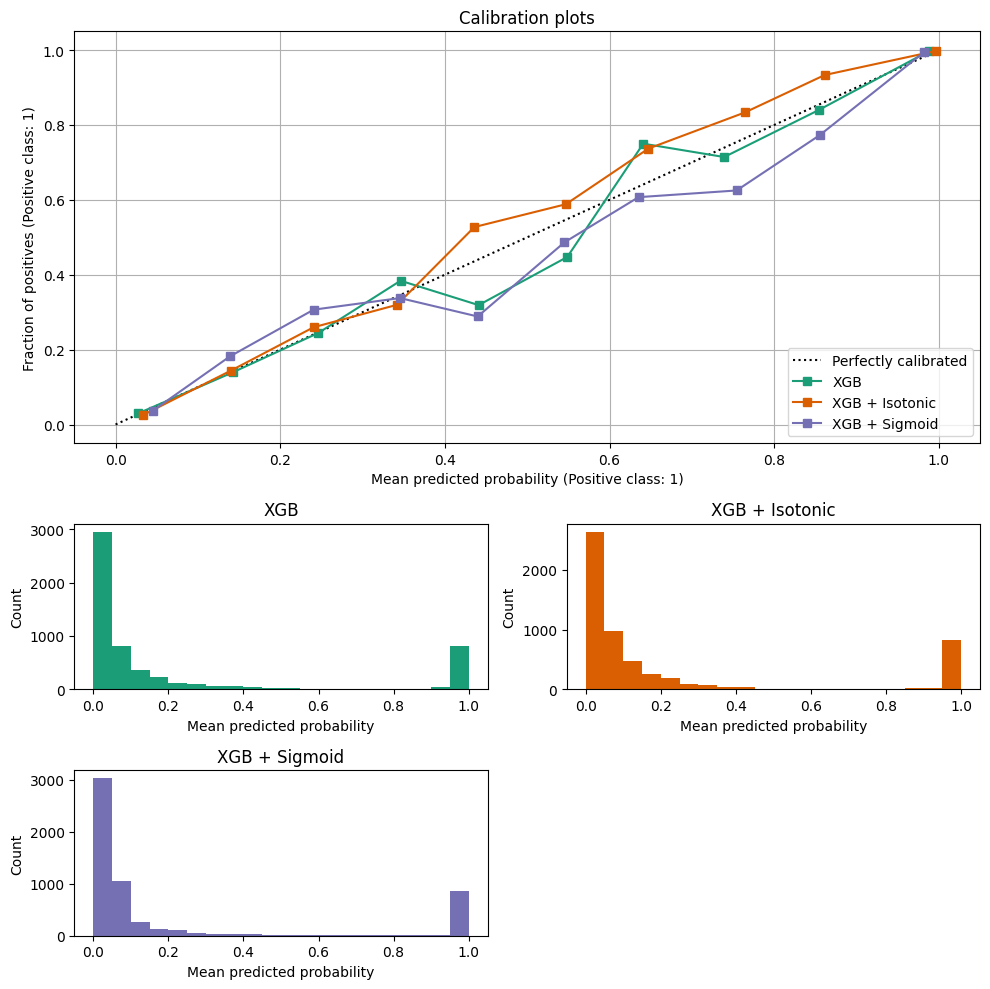

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [ ]:
y_pred = pd.DataFrame({'trueclass': y_test['loan_status'],
                        "prob": y_pred_prob})

# Populate the arrays for the strategy table with a for loop
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]
thresholds = []
bad_rates = []
num_accepted = []

for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(y_pred['prob'], rate)
    # Add the threshold value to the list of thresholds
    thresholds.append(thresh)
    # Reassign the loan_status value using the threshold
    y_pred['class'] = y_pred['prob'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = y_pred[y_pred['class'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['trueclass']) / len(accepted_loans['trueclass'])))
    # Calculate number of accepted loans
    num_accepted.append(len(accepted_loans['trueclass']))
  
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates, num_accepted),
                        columns = ['Acceptance Rate','Threshold','Bad Rate', 'Loans Accepted'])

strat_df['Average Loan Amount'] = [int(x) for x in np.repeat(np.mean(X_test['loan_amnt']),len(accept_rates))]

strat_df['Portifolio Value'] = [int(x) for x in ((strat_df['Loans Accepted'] * (1 - strat_df['Bad Rate'])) * strat_df['Average Loan Amount']) - (strat_df['Loans Accepted'] * strat_df['Bad Rate'] * strat_df['Average Loan Amount'])]

strat_df

,Acceptance Rate,Threshold,Bad Rate,Loans Accepted,Average Loan Amount,Portifolio Value
0,1.00000,1.00000,0.21634,5727,9704,31528296
1,0.95000,0.99736,0.17500,5440,9704,34313344
2,0.90000,0.99012,0.12922,5154,9704,37088688
3,0.85000,0.86606,0.07868,4868,9704,39805808
4,0.80000,0.30247,0.05479,4581,9704,39582616
5,0.75000,0.18514,0.04284,4295,9704,38107608
6,0.70000,0.13062,0.03642,4009,9704,36069768
7,0.65000,0.09661,0.02875,3722,9704,34041632
8,0.60000,0.07510,0.02532,3436,9704,31654448
9,0.55000,0.05919,0.02063,3150,9704,29306080


In [ ]:
y_pred = pd.DataFrame({'trueclass': y_test['loan_status'],
                        "prob": y_pred_prob_1})

# Populate the arrays for the strategy table with a for loop
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]
thresholds = []
bad_rates = []
num_accepted = []

for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(y_pred['prob'], rate)
    # Add the threshold value to the list of thresholds
    thresholds.append(thresh)
    # Reassign the loan_status value using the threshold
    y_pred['class'] = y_pred['prob'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = y_pred[y_pred['class'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['trueclass']) / len(accepted_loans['trueclass'])).round(3))
    # Calculate number of accepted loans
    num_accepted.append(len(accepted_loans['trueclass']))
  
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates, num_accepted),
                        columns = ['Acceptance Rate','Threshold','Bad Rate', 'Loans Accepted'])

strat_df['Average Loan Amount'] = [int(x) for x in np.repeat(np.mean(X_test['loan_amnt']),len(accept_rates))]

strat_df['Portifolio Value'] = [int(x) for x in ((strat_df['Loans Accepted'] * (1 - strat_df['Bad Rate'])) * strat_df['Average Loan Amount']) - (strat_df['Loans Accepted'] * strat_df['Bad Rate'] * strat_df['Average Loan Amount'])]

strat_df

,Acceptance Rate,Threshold,Bad Rate,Loans Accepted,Average Loan Amount,Portifolio Value
0,1.00000,0.98544,0.21600,5727,9704,31566490
1,0.95000,0.98503,0.17500,5440,9704,34313344
2,0.90000,0.98398,0.12900,5154,9704,37110696
3,0.85000,0.94844,0.07800,4868,9704,39869776
4,0.80000,0.25741,0.05500,4581,9704,39564081
5,0.75000,0.13887,0.04400,4295,9704,38010956
6,0.70000,0.09312,0.03500,4009,9704,36180102
7,0.65000,0.07067,0.02800,3722,9704,34095663
8,0.60000,0.05964,0.02100,3436,9704,31942540
9,0.55000,0.05221,0.01900,3150,9704,29406031


In [ ]:
y_pred = pd.DataFrame({'trueclass': y_test['loan_status'],
                        "prob": y_pred_prob_2})

# Populate the arrays for the strategy table with a for loop
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]
thresholds = []
bad_rates = []
num_accepted = []

for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(y_pred['prob'], rate)
    # Add the threshold value to the list of thresholds
    thresholds.append(thresh)
    # Reassign the loan_status value using the threshold
    y_pred['class'] = y_pred['prob'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = y_pred[y_pred['class'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['trueclass']) / len(accepted_loans['trueclass'])).round(3))
    # Calculate number of accepted loans
    num_accepted.append(len(accepted_loans['trueclass']))
  
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates, num_accepted),
                        columns = ['Acceptance Rate','Threshold','Bad Rate', 'Loans Accepted'])

strat_df['Average Loan Amount'] = [int(x) for x in np.repeat(np.mean(X_test['loan_amnt']),len(accept_rates))]

strat_df['Portifolio Value'] = [int(x) for x in ((strat_df['Loans Accepted'] * (1 - strat_df['Bad Rate'])) * strat_df['Average Loan Amount']) - (strat_df['Loans Accepted'] * strat_df['Bad Rate'] * strat_df['Average Loan Amount'])]

strat_df

,Acceptance Rate,Threshold,Bad Rate,Loans Accepted,Average Loan Amount,Portifolio Value
0,1.00000,1.00000,0.21600,5727,9704,31566490
1,0.95000,1.00000,0.21600,5727,9704,31566490
2,0.90000,1.00000,0.21600,5727,9704,31566490
3,0.85000,0.85514,0.07900,4868,9704,39775298
4,0.80000,0.26998,0.05500,4581,9704,39564081
5,0.75000,0.18738,0.04400,4295,9704,38010956
6,0.70000,0.13916,0.03500,4009,9704,36180102
7,0.65000,0.10890,0.02800,3723,9704,34104824
8,0.60000,0.08749,0.02000,3436,9704,32009226
9,0.55000,0.06969,0.01900,3150,9704,29406031
